# Data Preprocessing: Assignment 1

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


At first we need to look at the correlation between the different features to the saleprice in order to determine which has the highest affect on the sale price.

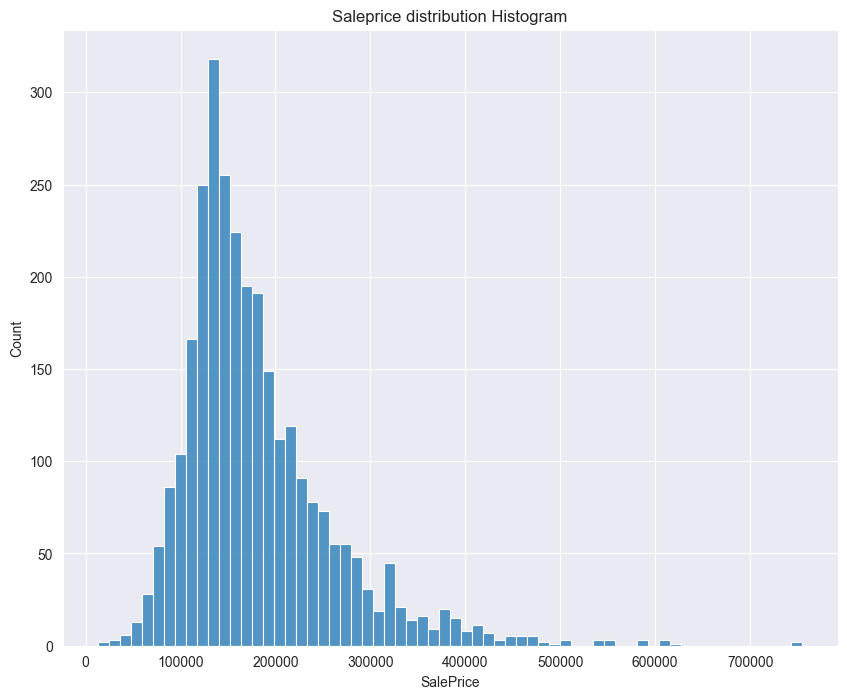

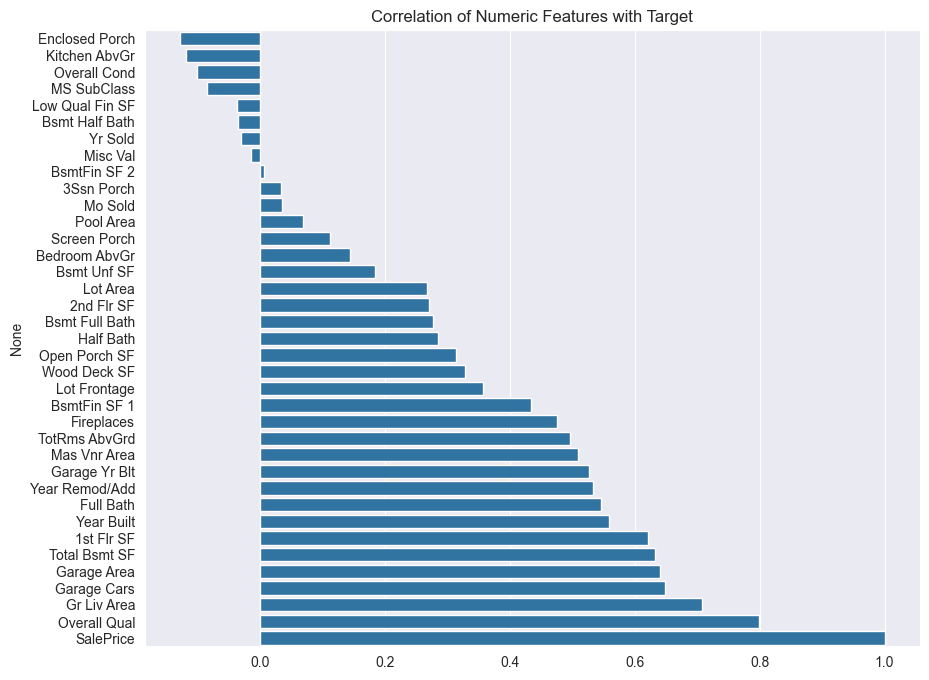

Quality split
1    1108
2    1334
3     488
Name: count, dtype: int64


In [56]:
datapath = "Data/AmesHousing.csv"

df_raw = pd.read_csv(datapath)

df_raw.drop(columns=["PID","Order"], inplace=True)

plt.figure(figsize=(10,8))
sns.histplot(data=df_raw, x='SalePrice')
plt.title("Saleprice distribution Histogram")
plt.show()

corr = df_raw.corr(numeric_only=True)['SalePrice'].sort_values()
plt.figure(figsize=(10,8))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Correlation of Numeric Features with Target")
plt.show()

df_raw['Quality split'] = pd.qcut(
    df_raw['Overall Qual'],
    q=3,                 # 4 roughly equal-sized groups
    labels=[1, 2, 3]
)


print(df_raw['Quality split'].value_counts().sort_index())

The dataset is stratified with 'Overall quality' in 4 different bins.  the Overall quality feature was selected because it was the numerical feature with the strongest correlation to SalePrice. The following Shows the prices in the 4 quality bins. The quality bins can be seen as Low quality, Medium-low quality, Medium-high quality, and High-quality. This shows an increasing trend between quality and sale price

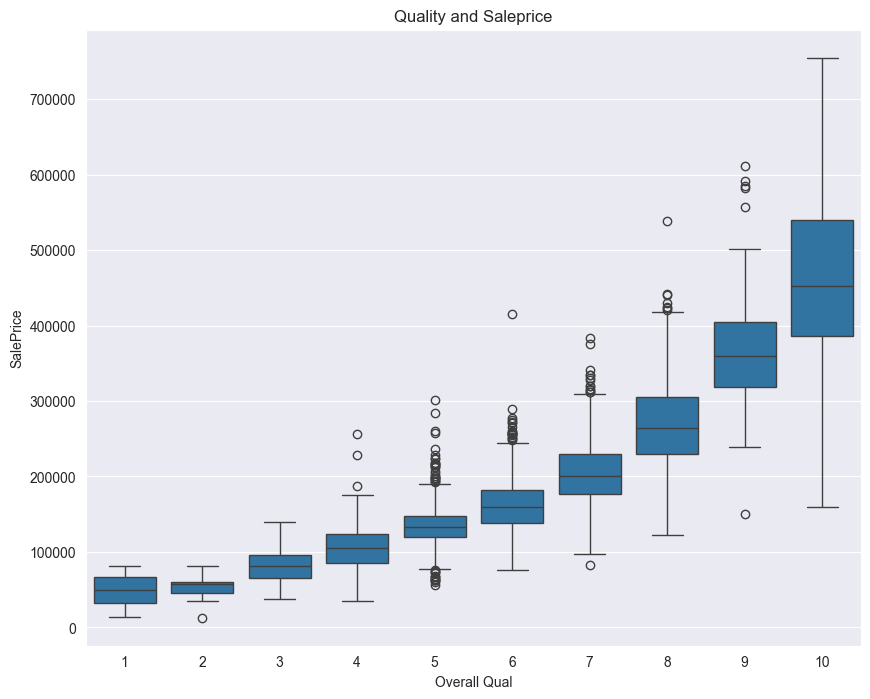

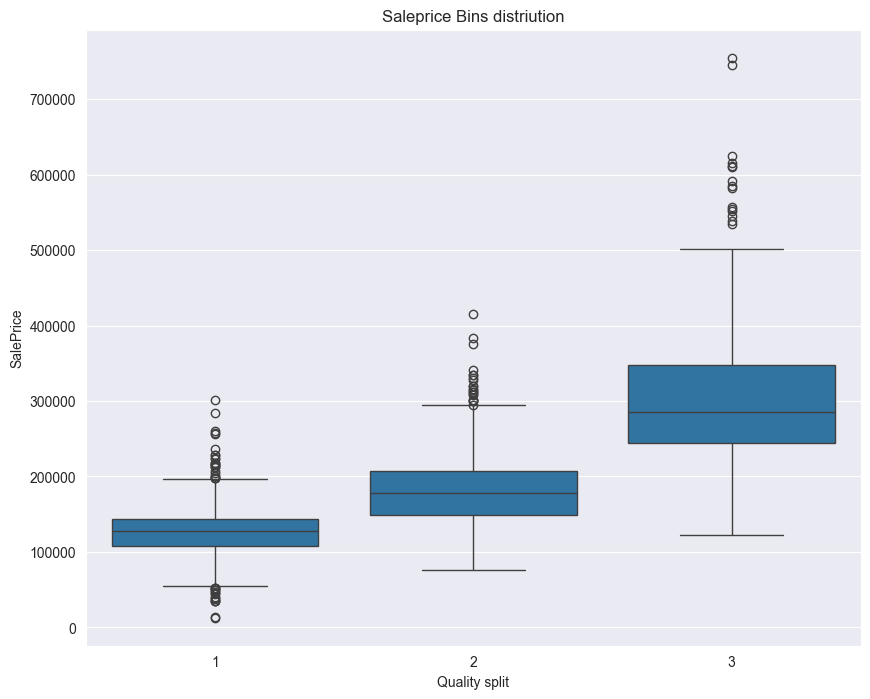

In [57]:
plt.figure(figsize=(10,8))
sns.boxplot(data=df_raw, x='Overall Qual',y='SalePrice')
plt.title("Quality and Saleprice")
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(data=df_raw, x='Quality split',y='SalePrice')
plt.title("Saleprice Bins distriution")
plt.show()


In [58]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df_raw, df_raw["Quality split"]):
 strat_train_set = df_raw.iloc[train_idx].copy()
 strat_test_set = df_raw.iloc[test_idx].copy()



def proportions(s): return s.value_counts(normalize=True).sort_index()

prop_table = pd.DataFrame({
 'overall': proportions(df_raw['Quality split']),
 'train': proportions(strat_train_set['Quality split']),
 'test': proportions(strat_test_set['Quality split'])})

print(prop_table)

for s in (strat_train_set, strat_test_set):
 s.drop(columns=["Quality split"], inplace=True)

X_train = strat_train_set.drop(columns=['SalePrice'])
y_train = strat_train_set['SalePrice'].copy()
X_test = strat_test_set.drop(columns=['SalePrice'])
y_test = strat_test_set['SalePrice'].copy()


                overall     train      test
Quality split                              
1              0.378157  0.377986  0.378840
2              0.455290  0.455205  0.455631
3              0.166553  0.166809  0.165529


Linear regression, with some help from ChatGPT

In [59]:

# --------------------------
# 1️⃣ Select numeric + strong categorical features
# --------------------------
# Example strong categorical features (you can adjust)
strong_cat_cols = ['Neighborhood', 'HouseStyle', 'ExterQual', 'KitchenQual', 'BsmtQual']
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'SalePrice']  # drop target if present

# Filter categorical columns to those in the dataset
cat_cols = [c for c in strong_cat_cols if c in X_train.columns]

# --------------------------
# 2️⃣ Create transformers
# --------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, cat_cols)
])

# --------------------------
# 3️⃣ Build pipeline with log-transform
# --------------------------
linreg = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

# Log-transform target
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# --------------------------
# 4️⃣ Fit and predict
# --------------------------
linreg.fit(X_train, y_train_log)
y_pred_log = linreg.predict(X_test)
y_pred = np.expm1(y_pred_log)  # convert back to original scale

# --------------------------
# 5️⃣ Evaluate
# --------------------------
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:,.2f}")
print(f"Linear Regression R^2: {r2:.3f}")# Log-transform target


Linear Regression RMSE: 20,030.36
Linear Regression R^2: 0.928


Polynomial features, with ChatGPT help

In [60]:

#Polynomial features

poly_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])

# Fit
poly_pipeline.fit(X_train, y_train_log)


# Predict
y_pred_poly = poly_pipeline.predict(X_test)

# Evaluate
rmse_poly = np.sqrt(mean_squared_error(y_test_log, y_pred_poly))
r2_poly = r2_score(y_test_log, y_pred_poly)

print()
print(f"Polynomial Linear Regression RMSE: {rmse_poly:,.2f}")
print(f"Polynomial Linear Regression R^2: {r2_poly:.3f}")


Polynomial Linear Regression RMSE: 0.32
Polynomial Linear Regression R^2: 0.278


Random forest regressor, with ChatGPT help

In [61]:

rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=42
    ))
])

# Fit
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print()
print(f"Random Forest RMSE: {rmse_rf:,.2f}")
print(f"Random Forest R^2: {r2_rf:.3f}")




Random Forest RMSE: 21,828.41
Random Forest R^2: 0.915
